In [76]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.decomposition import PCA

# Load Data

In [77]:
# Load the original data
file_path = "final_chosen_embeddings.csv"
embeddings_df = pd.read_csv(file_path)
print(embeddings_df.shape)
embeddings_df = embeddings_df.apply(pd.to_numeric, errors='coerce')


(14387, 1024)


In [78]:
embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.097502,0.041157,0.015847,-0.116904,0.104728,-0.032803,-0.052221,0.008763,-0.063743,-0.077305,...,-0.048663,0.011981,-0.134694,-0.069441,0.057752,-0.039609,-0.067868,0.020727,-0.009816,0.051319
1,0.087380,0.077887,0.000883,-0.055398,0.136644,0.014458,-0.156743,-0.022596,-0.039086,-0.133126,...,-0.053697,-0.050823,-0.090344,-0.106265,0.060197,-0.055505,-0.101654,0.002984,0.004396,0.119960
2,0.081449,0.064213,0.031846,-0.101599,0.114083,-0.010752,-0.076092,0.022347,-0.052153,-0.050759,...,-0.004997,-0.022449,-0.071919,-0.095955,0.071172,-0.074921,-0.079598,0.026687,-0.058923,0.085925
3,0.054779,0.087883,0.050499,-0.128000,0.137137,-0.040081,-0.113433,-0.017044,-0.008265,-0.125296,...,-0.023547,-0.044238,-0.086095,-0.134322,0.049108,-0.037854,-0.021380,-0.005630,-0.004228,0.070353
4,0.073225,0.100251,-0.008033,-0.054263,0.141893,0.003107,-0.105862,-0.010538,-0.036693,-0.118309,...,0.000012,-0.008275,-0.094060,-0.072182,0.018819,-0.020401,-0.046540,0.025473,-0.015419,0.092573


Too many covariates in the data frame now, to allow interpretability and reduce overfitting, we do PCA here to reduce dimension

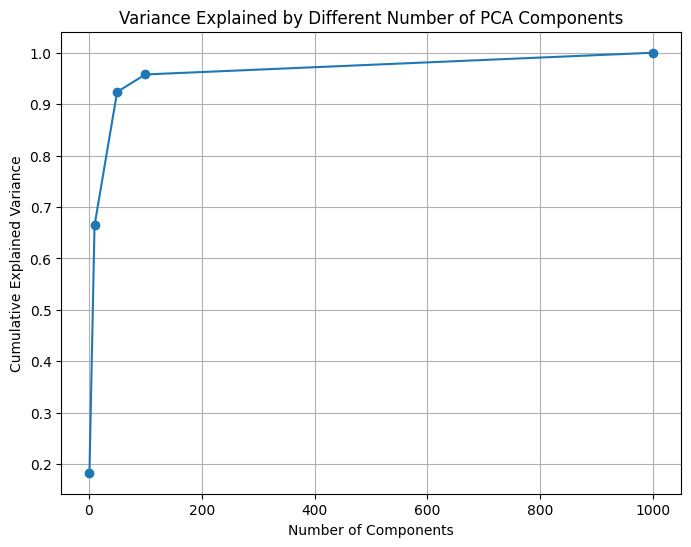

In [40]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

# Assuming embedding_df is already loaded and contains the data to be reduced
# Calculate PCA for different number of components
explained_variance = []
components_range = [1, 10, 50, 100, 1000]
reduced_embeddings = {}  # Store reduced embeddings for each PCA configuration

for n in components_range:
    pca = PCA(n_components=n)
    reduced_data = pca.fit_transform(embeddings_df)  # Transform data
    reduced_embeddings[n] = reduced_data  # Store reduced embeddings
    explained_variance.append(sum(pca.explained_variance_ratio_))

# Plot the variance explained for different number of components
plt.figure(figsize=(8, 6))
plt.plot(components_range, explained_variance, marker='o')
plt.title('Variance Explained by Different Number of PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()


In [41]:
explained_variance #(0.9236476555832881) FOR 50

[np.float64(0.18336436296599165),
 np.float64(0.6641738025112166),
 np.float64(0.9236476555832881),
 np.float64(0.9577021595381022),
 np.float64(0.9999497706267522)]

In [79]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the original data
file_path = "input_bcell.csv"
original_df = pd.read_csv(file_path)
original_df.shape

# Extract the covariates (all columns between 5th and second-to-last)
covariates = original_df.iloc[:, 5:-1].values

# Scale the covariates using StandardScaler
scaler = StandardScaler()
scaled_covariates = scaler.fit_transform(covariates)

# Convert the scaled covariates to a DataFrame
scaled_covariates_df = pd.DataFrame(scaled_covariates, columns=original_df.columns[5:-1])

# Assuming embedding_df is already loaded and needs to be reduced to 2D
# Perform PCA to reduce embedding_df to 2 dimensions
pca = PCA(n_components=50)
embedding_2d = pca.fit_transform(embeddings_df)

# Convert the 2D embedding to a DataFrame
scaled_embedding_2d = pd.DataFrame(embedding_2d)

# Concatenate the 2D embeddings with the scaled covariates
combined_df = pd.concat([scaled_embedding_2d, scaled_covariates_df], axis=1)

# extract label
label = original_df["target"]
combined_df["target"]=label

# Display the first few rows of the resulting DataFrame
print(combined_df.head())


          0         1         2         3         4         5         6  \
0  0.130986 -0.841194  0.244296 -0.327157  0.358919  0.416627 -0.046346   
1  0.386893 -0.968927 -0.258601  0.560947  0.127285  0.560037  0.220887   
2 -0.368636 -0.521758  0.266631  0.111659  0.485981 -0.048439 -0.167204   
3  0.583055 -0.633835 -0.460227  0.090961  0.320210  0.568618  0.102708   
4  0.509345 -0.685261 -0.216036  0.102097  0.004009  0.253212 -0.054365   

          7         8         9  ...        49  chou_fasman     emini  \
0 -0.101677  0.082235 -0.362470  ...  0.045556     0.170670 -0.219985   
1  0.292103  0.146383 -0.382259  ...  0.026651    -1.800991 -0.543068   
2  0.300192 -0.177946 -0.067067  ... -0.063127    -1.143771  1.459553   
3  0.237914  0.136653 -0.027776  ... -0.085042     3.328533  0.917587   
4  0.069683 -0.145268 -0.114928  ... -0.075505     1.757616  0.522983   

   kolaskar_tongaonkar    parker  isoelectric_point  aromaticity  \
0            -0.059261  0.230006          

## deal with class imbalance

In [96]:
from sklearn.utils import resample

# Separate majority and minority classes
majority_class = combined_df[combined_df["target"] == combined_df["target"].value_counts().idxmax()]
minority_class = combined_df[combined_df["target"] == combined_df["target"].value_counts().idxmin()]

# Downsample majority class
majority_downsampled = resample(majority_class,
                                 replace=False,  # Sample without replacement
                                 n_samples=len(minority_class),  # Match the minority class size
                                 random_state=42)  # For reproducibility

# Combine minority class with downsampled majority class
balanced_df = pd.concat([majority_downsampled, minority_class])

# Shuffle the combined dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check class distribution after downsampling
print("\nClass distribution after downsampling:")
print(balanced_df["target"].value_counts())



Class distribution after downsampling:
target
1    3902
0    3902
Name: count, dtype: int64


In [97]:
balanced_df.to_csv('PCA_df.csv', index=False)

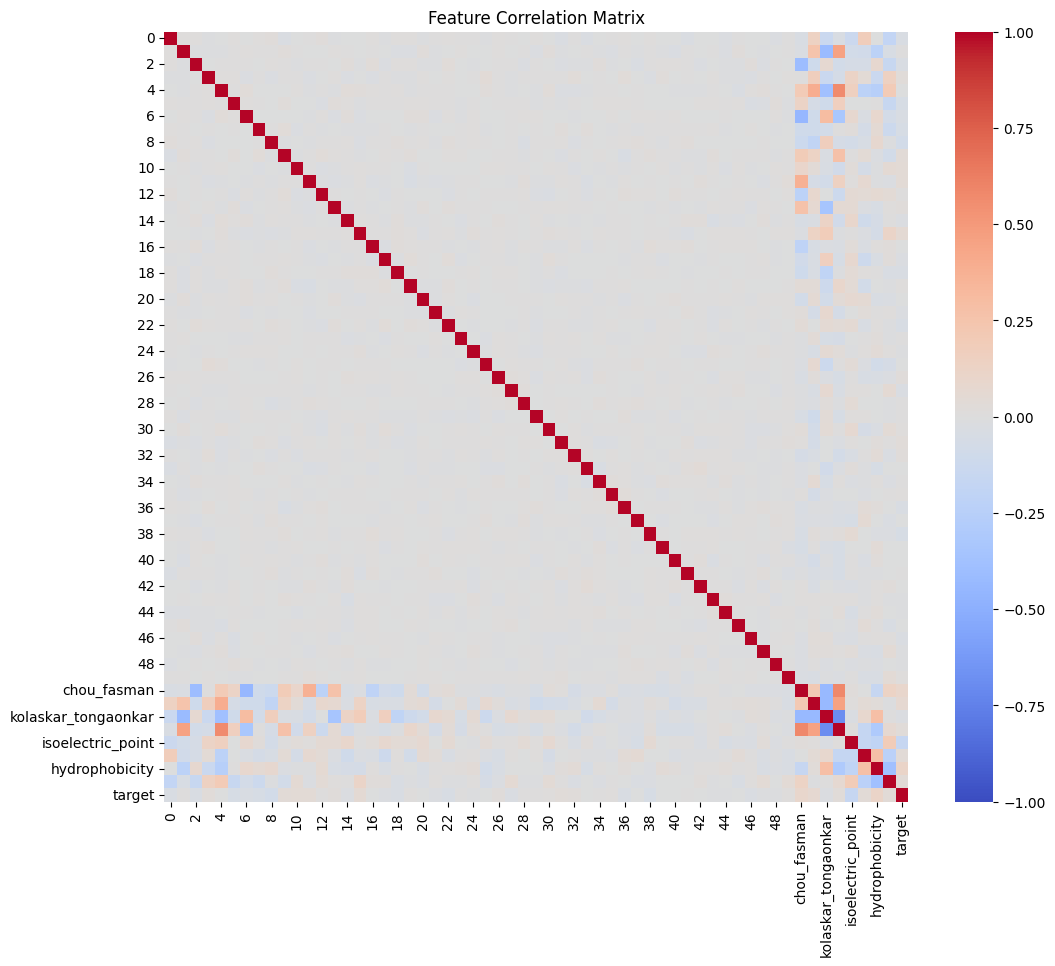

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(balanced_df.corr(), annot=False, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()


## Test and Compare Classification Methods - given large amount of features, we use shallower and less trees to prevent overfitting

In [100]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier  # CART
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier  # Neural Network
from sklearn.linear_model import LogisticRegression  # Logistic Regression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import xgboost as xgb

# Split features (X) and target (y)
balanced_df.columns = balanced_df.columns.astype(str)
X = balanced_df.drop(columns=['target'])
y = balanced_df['target']

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the classifiers and their respective hyperparameter grids
classifiers = {
    'CART (Decision Tree)': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'max_depth': [5, 10, 20, None],  # Reduced range
            'min_samples_split': [5, 10, 20],  # Simplified
            'min_samples_leaf': [5, 10, 50]  # Removed larger values
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'n_estimators': [10, 20, 50, None],  # Focus on fewer trees
            'max_depth': [5, 10, 20, None],  # Reduced depth range
            'min_samples_split': [5, 10, 20],  # Simplified
            'min_samples_leaf': [5, 10, 50]  # Removed larger values
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(eval_metric='mlogloss'),
        'param_grid': {
            'n_estimators': [20, 50, 100, None],  # Reduced
            'max_depth': [3, 5, 10, None],  # Focus on smaller depths for interpretability
            'learning_rate': [0.001, 0.01, 0.1]  # Removed extreme values
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=500),
        'param_grid': {
            'C': [0.1, 1, 10],  # Kept the same
            'solver': ['liblinear'],  # Removed 'saga' for simplicity
            'penalty': ['l2']  # Kept the same
        }
    }
}

# Store results
results = []

# Perform GridSearchCV for each classifier
for clf_name, clf_info in classifiers.items():
    model = clf_info['model']
    param_grid = clf_info['param_grid']

    # Perform grid search to find the best hyperparameters
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Make predictions using the best model
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Get predicted probabilities for AUC calculation (for binary classification)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)  # Calculate AUC

    # Store the results
    results.append({
        'Classifier': clf_name,
        'Best Hyperparameters': grid_search.best_params_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Confusion Matrix': cm
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)

/Users/xingyugong/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
180 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/xingyugong/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/xingyugong/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/xingyugong/.julia/conda/3/aarch64/lib/python3.10/site-packages/sklearn/base.py", line 6

             Classifier                               Best Hyperparameters  \
0  CART (Decision Tree)  {'max_depth': 10, 'min_samples_leaf': 50, 'min...   
1         Random Forest  {'max_depth': None, 'min_samples_leaf': 5, 'mi...   
2               XGBoost  {'learning_rate': 0.1, 'max_depth': 10, 'n_est...   
3   Logistic Regression  {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}   

   Accuracy  Precision    Recall  F1-Score       AUC          Confusion Matrix  
0  0.756566   0.763291  0.757538  0.760404  0.824931  [[578, 187], [193, 603]]  
1  0.748879   0.748768  0.763819  0.756219  0.827006  [[561, 204], [188, 608]]  
2  0.800769   0.800496  0.811558  0.805989  0.876812  [[604, 161], [150, 646]]  
3  0.605381   0.616580  0.597990  0.607143  0.643047  [[469, 296], [320, 476]]  


In [101]:
results_df

,Classifier,Best Hyperparameters,Accuracy,Precision,Recall,F1-Score,AUC,Confusion Matrix
0,CART (Decision Tree),"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.756566,0.763291,0.757538,0.760404,0.824931,"[[578, 187], [193, 603]]"
1,Random Forest,"{'max_depth': None, 'min_samples_leaf': 5, 'mi...",0.748879,0.748768,0.763819,0.756219,0.827006,"[[561, 204], [188, 608]]"
2,XGBoost,"{'learning_rate': 0.1, 'max_depth': 10, 'n_est...",0.800769,0.800496,0.811558,0.805989,0.876812,"[[604, 161], [150, 646]]"
3,Logistic Regression,"{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}",0.605381,0.616580,0.597990,0.607143,0.643047,"[[469, 296], [320, 476]]"


In [102]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import numpy as np

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training and testing
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Define a simple neural network architecture
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 2)  # Binary classification (2 output neurons: Positive or Negative)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]  # The number of features (embedding dimensions)
model = SimpleNN(input_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters (can be tuned)
epochs = 20
batch_size = 32
learning_rate = 0.001

# Dictionary to store best hyperparameters
best_hyperparameters = {
    "epochs": epochs,
    "batch_size": batch_size,
    "learning_rate": learning_rate
}

# Train the model
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

# Evaluate the model
model.eval()
y_pred = []
y_true = []
y_prob = []  # To store predicted probabilities

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Predicted class labels
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

        # Get predicted probabilities for AUC calculation
        prob = torch.softmax(outputs, dim=1)[:, 1]  # Get the probabilities for the positive class
        y_prob.extend(prob.numpy())

# Calculate metrics
accuracy_nn = accuracy_score(y_true, y_pred)
precision_nn = precision_score(y_true, y_pred)
recall_nn = recall_score(y_true, y_pred)
f1_nn = f1_score(y_true, y_pred)
cm_nn = confusion_matrix(y_true, y_pred)
auc_nn = roc_auc_score(y_true, y_prob)  # Calculate AUC

# Add the results and best hyperparameters to the results_df
results_df.loc[len(results_df)] = [
    "Simple Neural Network",
    best_hyperparameters,  # Store the hyperparameters
    accuracy_nn,
    precision_nn,
    recall_nn,
    f1_nn,
    auc_nn,
    cm_nn
]

Epoch 1/20, Loss: 0.6609253117016384
Epoch 2/20, Loss: 0.6328957506588527
Epoch 3/20, Loss: 0.6133125813639894
Epoch 4/20, Loss: 0.5947189673173184
Epoch 5/20, Loss: 0.5749067103072089
Epoch 6/20, Loss: 0.5500982329249382
Epoch 7/20, Loss: 0.532802768659835
Epoch 8/20, Loss: 0.5100183266462112
Epoch 9/20, Loss: 0.48638025747270003
Epoch 10/20, Loss: 0.467016016342202
Epoch 11/20, Loss: 0.4473750679468622
Epoch 12/20, Loss: 0.43369985782370274
Epoch 13/20, Loss: 0.41606905782709314
Epoch 14/20, Loss: 0.4076884055928308
Epoch 15/20, Loss: 0.3848025399659361
Epoch 16/20, Loss: 0.36783615955892873
Epoch 17/20, Loss: 0.35419434578899217
Epoch 18/20, Loss: 0.3400738504715264
Epoch 19/20, Loss: 0.31930650713644465
Epoch 20/20, Loss: 0.3101319942471324


In [103]:
from tabulate import tabulate

# Convert the results DataFrame to a pretty table format
pretty_table = tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False)

# Print the pretty table
print("With Multimodality:")
print(pretty_table)

With Multimodality:
+-----------------------+----------------------------------------------------------------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|      Classifier       |                                  Best Hyperparameters                                  |      Accuracy      |     Precision      |       Recall       |      F1-Score      |        AUC         | Confusion Matrix |
+-----------------------+----------------------------------------------------------------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
| CART (Decision Tree)  |           {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 10}           | 0.7565663036515055 | 0.7632911392405063 | 0.757537688442211  | 0.7604035308953342 | 0.8249310276874569 |    [[578 187]    |
|                       

## Performance without embeddings

In [104]:
combined_df_null=balanced_df.iloc[:, 50:]
#print(combined_df_null.head)

In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier  # CART
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier  # Neural Network
from sklearn.linear_model import LogisticRegression  # Logistic Regression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import xgboost as xgb

# Split features (X) and target (y)
X = combined_df_null.drop(columns=['target'])
y = combined_df_null['target']

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the classifiers and their respective hyperparameter grids
classifiers = {
    'CART (Decision Tree)': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'max_depth': [5, 10, 20, None],  # Reduced range
            'min_samples_split': [5, 10, 20],  # Simplified
            'min_samples_leaf': [5, 10, 50]  # Removed larger values
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'n_estimators': [25, 50, 100],  # Focus on fewer trees
            'max_depth': [5, 10, None],  # Reduced depth range
            'min_samples_split': [10, 20],  # Simplified
            'min_samples_leaf': [10, 20, 50]  # Removed larger values
        }
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(eval_metric='mlogloss'),
        'param_grid': {
            'n_estimators': [25, 50, 100],  # Reduced
            'max_depth': [3, 5],  # Focus on smaller depths for interpretability
            'learning_rate': [0.01, 0.1]  # Removed extreme values
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=500),
        'param_grid': {
            'C': [0.1, 1, 10],  # Kept the same
            'solver': ['liblinear'],  # Removed 'saga' for simplicity
            'penalty': ['l2']  # Kept the same
        }
    }
}

# Store results
results = []

# Perform GridSearchCV for each classifier
for clf_name, clf_info in classifiers.items():
    model = clf_info['model']
    param_grid = clf_info['param_grid']

    # Perform grid search to find the best hyperparameters
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Make predictions using the best model
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Get predicted probabilities for AUC calculation (for binary classification)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)  # Calculate AUC

    # Store the results
    results.append({
        'Classifier': clf_name,
        'Best Hyperparameters': grid_search.best_params_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC': auc,
        'Confusion Matrix': cm
    })

# Convert results to a DataFrame
results_df_null = pd.DataFrame(results)

# Print the results
print(results_df_null)

             Classifier                               Best Hyperparameters  \
0  CART (Decision Tree)  {'max_depth': 10, 'min_samples_leaf': 5, 'min_...   
1         Random Forest  {'max_depth': None, 'min_samples_leaf': 10, 'm...   
2               XGBoost  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...   
3   Logistic Regression  {'C': 0.1, 'penalty': 'l2', 'solver': 'libline...   

   Accuracy  Precision    Recall  F1-Score       AUC          Confusion Matrix  
0  0.769379   0.782383  0.758794  0.770408  0.840158  [[597, 168], [192, 604]]  
1  0.781550   0.781908  0.792714  0.787274  0.865415  [[589, 176], [165, 631]]  
2  0.795003   0.806701  0.786432  0.796438  0.871418  [[615, 150], [170, 626]]  
3  0.596413   0.602978  0.610553  0.606742  0.627009  [[445, 320], [310, 486]]  


In [110]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import numpy as np

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training and testing
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Define a simple neural network architecture
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 2)  # Binary classification (2 output neurons: Positive or Negative)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Initialize the model
input_dim = X_train.shape[1]  # The number of features (embedding dimensions)
model = SimpleNN(input_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Hyperparameters (can be tuned)
epochs = 20
batch_size = 32
learning_rate = 0.001

# Dictionary to store best hyperparameters
best_hyperparameters = {
    "epochs": epochs,
    "batch_size": batch_size,
    "learning_rate": learning_rate
}

# Train the model
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

# Evaluate the model
model.eval()
y_pred = []
y_true = []
y_prob = []  # To store predicted probabilities

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Predicted class labels
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

        # Get predicted probabilities for AUC calculation
        prob = torch.softmax(outputs, dim=1)[:, 1]  # Get the probabilities for the positive class
        y_prob.extend(prob.numpy())

# Calculate metrics
accuracy_nn = accuracy_score(y_true, y_pred)
precision_nn = precision_score(y_true, y_pred)
recall_nn = recall_score(y_true, y_pred)
f1_nn = f1_score(y_true, y_pred)
cm_nn = confusion_matrix(y_true, y_pred)
auc_nn = roc_auc_score(y_true, y_prob)  # Calculate AUC

# Add the results and best hyperparameters to the results_df
results_df_null.loc[len(results_df_null)] = [
    "Simple Neural Network",
    best_hyperparameters,  # Store the hyperparameters
    accuracy_nn,
    precision_nn,
    recall_nn,
    f1_nn,
    auc_nn,
    cm_nn
]

Epoch 1/20, Loss: 0.6635016701659378
Epoch 2/20, Loss: 0.6423742611493383
Epoch 3/20, Loss: 0.628737635454353
Epoch 4/20, Loss: 0.6145200107474716
Epoch 5/20, Loss: 0.601011856782193
Epoch 6/20, Loss: 0.5850621574387258
Epoch 7/20, Loss: 0.5756817209173222
Epoch 8/20, Loss: 0.5637412180705946
Epoch 9/20, Loss: 0.5575388755117144
Epoch 10/20, Loss: 0.5475594468262731
Epoch 11/20, Loss: 0.539327685930291
Epoch 12/20, Loss: 0.5320482062441962
Epoch 13/20, Loss: 0.5228334482835264
Epoch 14/20, Loss: 0.5174752070891614
Epoch 15/20, Loss: 0.5109589565165189
Epoch 16/20, Loss: 0.5079092758954787
Epoch 17/20, Loss: 0.5028594832639305
Epoch 18/20, Loss: 0.49389148153820817
Epoch 19/20, Loss: 0.4879454082372237
Epoch 20/20, Loss: 0.484138408485724


In [111]:
from tabulate import tabulate

# Convert the results DataFrame to a pretty table format
pretty_table = tabulate(results_df_null, headers='keys', tablefmt='pretty', showindex=False)

# Print the pretty table
print("Tabular Data Only:")
print(pretty_table)

Tabular Data Only:
+-----------------------+------------------------------------------------------------------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|      Classifier       |                                   Best Hyperparameters                                   |      Accuracy      |     Precision      |       Recall       |      F1-Score      |        AUC         | Confusion Matrix |
+-----------------------+------------------------------------------------------------------------------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
| CART (Decision Tree)  |            {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}             | 0.769378603459321  | 0.7823834196891192 | 0.7587939698492462 | 0.7704081632653061 | 0.8401583078792657 |    [[597 168]    |
|                